# Surface Energy Budget in 6 hourly single column data
This looks at the hottest day of the year using 6 hourly data i.e. can we predict hottest day of year based on max input flux.

In [216]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v, g
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import calendar
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [303]:
# Calculate Drag coefficient from LH and other parameters in dataset
# def get_drag_coef(flux_lhe, temp_surf, temp_diseqb, rh, p_surf, evap_prefactor, wind_speed, sigma):
#     # Could also compute from sensible heat as a sanity check
#     temp_a = temp_surf - temp_diseqb
#     p_a = p_surf*sigma
#     rho = get_density(temp_a, p_a)
#     sphum_a = rh * sphum_sat(temp_a, p_a)
#     return flux_lhe / (evap_prefactor * L_v * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a))

def get_drag_coef(flux_t, temp_surf, temp_diseqb, wind_speed, sigma, p_surf=None, density=None):
    # From sensible heat as no evap fraction which can be 0.
    temp_a = temp_surf - temp_diseqb
    if density is None:
        if p_surf is None:
            raise ValueError('If density not given; surface pressure required')
        p_a = p_surf*sigma
        density = get_density(temp_a, p_a)
    return flux_t / (c_p * density * wind_speed * (temp_surf - temp_a * (1/sigma)**kappa))

def get_temp_rad(lwdn_sfc, opd):
    # Returns radiative temperature, T_r, such that LW_down = sigma T_r^4 (1 - e^{-opd})
    emission_factor = 1 - np.exp(-opd)
    return (lwdn_sfc / emission_factor / Stefan_Boltzmann)**0.25

def get_water_column_depth(sphum, pressure):
    # sphum in kg/kg
    # pressure in Pa
    # Both should have first value at p=0 and last at p=p_surface
    # returns water column depth in kg/m^2
    return scipy.integrate.trapz(sphum, pressure, axis=0) / g

def get_opd_from_water_depth(water_col_depth, mass_abs_coef=0.05):
    # water col depth is mass of water vapour in column [kg/m^3]
    # mass absorption coefficient is in units of m^2/kg
    return water_col_depth * mass_abs_coef

In [304]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'flux_lhe', 'flux_t']
var_keep = {'gray': var_keep + ['swdn_sfc', 'lwup_sfc', 'lwdn_sfc'],
            'soc': var_keep + ['soc_toa_sw_down', 'soc_surf_flux_sw_down', 'soc_surf_flux_sw',
                               'soc_surf_flux_lw_down', 'soc_surf_flux_lw']}

def rename_ds_soc(ds):
    # Rename socrates dataset to match names of gray
    ds['lwup_sfc'] = ds.soc_surf_flux_lw + ds.soc_surf_flux_lw_down
    return ds.rename({'soc_surf_flux_sw': 'swdn_sfc', 'soc_surf_flux_lw_down': 'lwdn_sfc'})

# # DEFAULT experiment
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/column/'
# exp_name = ['evap=0']
exp_name = {'gray': 'base', 'soc': 'socrates'}


# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name['gray'])
if 'column_nml' in namelist:
    p_surface_approx = namelist['column_nml']['reference_sea_level_press']/100
else:
    p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']/100
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

if 'column_nml' in namelist:
    # In single column, wind is constant and has default value of 5m/s
    try:
        w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['column_init_cond_nml']['surface_wind']
    except KeyError:
        w_atm_const = 5
else:
    w_atm_const = None
try:
    evap_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['land_evap_prefactor']
except KeyError:
    evap_prefactor = 1
try:
    land_h_capacity_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['mixed_layer_nml']['land_h_capacity_prefactor']
except KeyError:
    land_h_capacity_prefactor = 1

n_exp = len(exp_name)
lat_range = slice(0, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
pressure_ft = 500
mass_abs_coef_water = 0.05          # approx mass abosrption coefficient for water (m^2/kg) in longwave according to chatGPT
# use_time_start = cftime.Datetime360Day(10, 1, 1)   # Year 10, January 1st
use_time_start = cftime.Datetime360Day(11, 1, 1)   # Year 1, January 1st
use_time_end = cftime.Datetime360Day(9000, 12, 30)  # Year 9000, December 30th (basically infinity)
ds_base = {}
pbar = tqdm(total=n_exp)
for i, key in enumerate(var_keep):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[key], decode_times=True).isel(lon=0, drop=True)
    ds_use = ds_use[var_keep[key]]
    if key == 'soc':
        ds_use = rename_ds_soc(ds_use)
    ds_use = ds_use.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range)
    ds_use['water_depth'] = ds_use['ps']*0 + get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull*100)
    # ds_use['water_depth'] = get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull.values*100)
    ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp.isel(pfull=0)**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp.isel(pfull=0)
    ds_use['rh'] = ds_use.sphum.isel(pfull=0) / sphum_sat(ds_use.temp.isel(pfull=0), ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_use['flux_sfc_dn_net'] = ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc - ds_use.flux_lhe - ds_use.flux_t
    # Compute deviation from lowest level and radiative temperature given surface optical depth
    ds_use['temp_diseqb_rad_gray'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, opd_lw_gray(ds_use.lat))
    ds_use['opd_water'] = get_opd_from_water_depth(ds_use.water_depth, mass_abs_coef_water)
    ds_use['temp_diseqb_rad_water'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, ds_use.opd_water)
    ds_use['mse'] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).isel(pfull=0)
    if 'drag_q' not in ds_use:
        # Need to change this if evap_prefactor changes with latitude
        ds_use['drag_q'] = get_drag_coef(ds_use.flux_t, ds_use.t_surf, ds_use.temp_diseqb, w_atm_const, sigma_near_surf, ds_use.ps)
    if 'w_atm' not in ds_use:
        ds_use['w_atm'] = ds_use['drag_q']*0+w_atm_const        # keep dimensions is useful for functions later
    ds_base[key] = ds_use.load()      # only keep after spin up
    pbar.update(1)

xr.testing.assert_identical(ds_base['gray'].time, ds_base['soc'].time)      # ensure times are the same
mixed_layer_depth = {'ocean': namelist['mixed_layer_nml']['depth']}
mixed_layer_depth['land'] = namelist['mixed_layer_nml']['land_h_capacity_prefactor'] * mixed_layer_depth['ocean']
ind_surf = 0
ind_ft = 1
pressure_ft_actual = float(ds_base['gray'].pfull[ind_ft]*100)
p_surface = float(ds_base['gray'].pfull[ind_surf]*100)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [305]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_lat = [np.floor(ds_base['gray'].lat[0]), np.ceil(ds_base['gray'].lat[-1])]
ax_lims_time = [0, 360]

In [306]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name['gray'].replace('_6_hours', ''), 'land.nc')
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]  # get the latitude coordinates of land
lat_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[0]
lat_land_min = (lat_land.min() + lat_ocean.max()) / 2           # show land in plots as average between ocean and land extrema

# Add heat capacity to dataset
for key in ds_base:
    ds_base[key]['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth['land'] *
                                                    (ds_base['gray'].lat > lat_land_min) + mixed_layer_depth['ocean'] *
                                                      (ds_base['gray'].lat < lat_land_min))

## Get Day and Night Datasets
Here, I select the dataset for night (9PM - 3AM) and day (9AM - 3PM) on each day; and average over all years to get a dataset with one value for each day of the year. I then smooth this over 20 days.

In [307]:
def get_smooth_array(ds, window=20, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_annual_mean_at_hour(ds, hour=12):
    # Returns dataset wth only a given hour at each day, and then for each day average over all years of dataset.
    # Returned dataset only has 360 time values (one for each year)
    if hour not in ds.time.dt.hour:
        raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_use = ds.where(ds.time.dt.hour == hour, drop=True)
    return ds_use.groupby("time.dayofyear").mean(dim="time")


smooth_sz = 20   # smooth over 20 days
ds = {key: get_smooth_array(get_annual_mean_at_hour(ds_base[key]), smooth_sz) for key in ds_base}
ds['diff'] = ds['gray'] - ds['soc']
exp_label = {'gray': 'Gray', 'soc': 'SOCRATES', 'diff': 'Gray-SOC'}
color_exp = {'gray': default_colors[0], 'soc': default_colors[1]}

In [261]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Surface Temperature
The surface temperature distributions are compared below. The crosses indicate the hottest day of the year, it occurs later and at the lowest land latitude for the SOCRATES simulation.

It is not surprising that the SOCRATES simulation is almost uniformly colder, as it has a larger surface albedo.

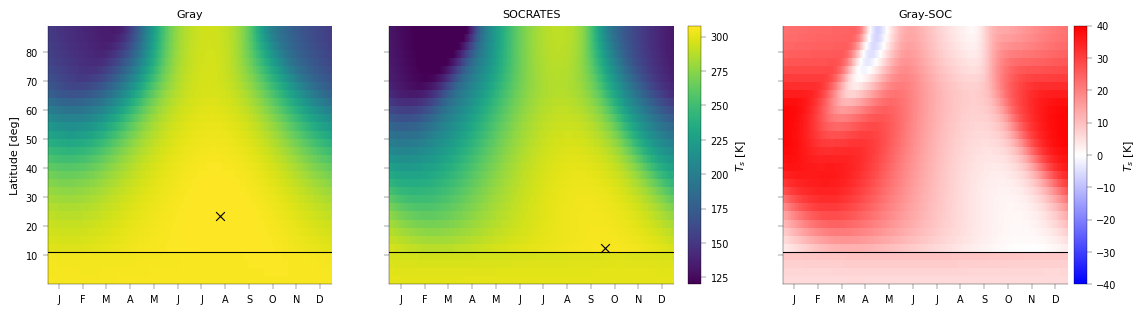

In [262]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].t_surf.transpose(), vmin=120, vmax=308)
    var = get_extrema_coordinates(ds[key].t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].t_surf.transpose(), vmin=-40, vmax=40, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Seasonal Cycle
From the above, it is clear that the seasonal cycle has a stronger seasonal amplitude over land. This is emphasized below.

The explanation for this is that there is a water vapour feedback in optical depth for SOCRATES, whereas optical depth is constant year round for Gray. I.e. in summer, more water vapour in atmosphere so larger optical depth and more downwelling longwave radiation at surface than if optical depth was constant. In winter see the opposite.

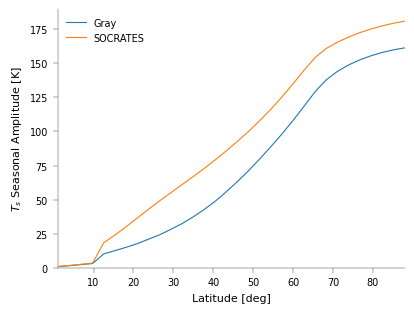

In [233]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for key in ['gray', 'soc']:
    ax.plot(ds[key].lat, ds[key].t_surf.max(dim='dayofyear')-ds[key].t_surf.min(dim='dayofyear'), color=color_exp[key], label=exp_label[key])
ax.legend()
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim(ax_lims_lat)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$T_s$ Seasonal Amplitude [K]')
plt.show()

### Latitudinal variation in temperature
Below we see that on a given day, the temperature peaks at the lowest land latitude for SOCRATES, while for the gray case, the peak in temperature is at a higher latitude.

The two dates are the date of the hottest gray (solid) and SOCRATES (dotted) temperature.

An explanation for this may be that the gradient in optical depth is larger for the SOCRATES simulation.

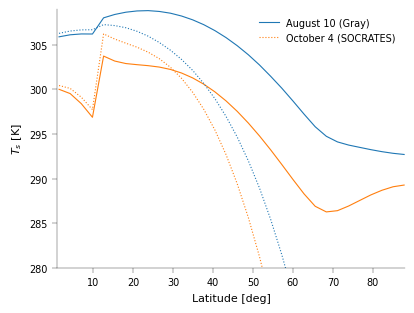

In [234]:
def get_month_day_from_ind(day_index):
    month = day_index // 30 + 1  # +1 for 1-based month
    day = day_index % 30 + 1     # +1 for 1-based day
    return month, day

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
for key2 in ['gray', 'soc']:
    day_plot = get_extrema_coordinates(ds[key2].t_surf, 'max')['dayofyear']
    var = get_month_day_from_ind(day_plot)
    label_use = f'{calendar.month_name[var[0]]} {var[1]}'
    for key in ['gray', 'soc']:
        ax.plot(ds[key].lat, ds[key].t_surf.isel(dayofyear=day_plot), color=color_exp[key],
                linestyle=':' if key2=='soc' else '-', label=label_use + f" ({exp_label[key]})" if key==key2 else None)
ax.set_ylim(280, 309)
ax.legend()
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('$T_s$ [K]')
ax.set_xlim(ax_lims_lat)
plt.show()

## MSE
The MSE distribution is similar to the surface temperature. The peak in MSE (faint circles) is at the same latitude but slightly later in the year. This is due relative humidity having a phase delay compared to surface temperature.

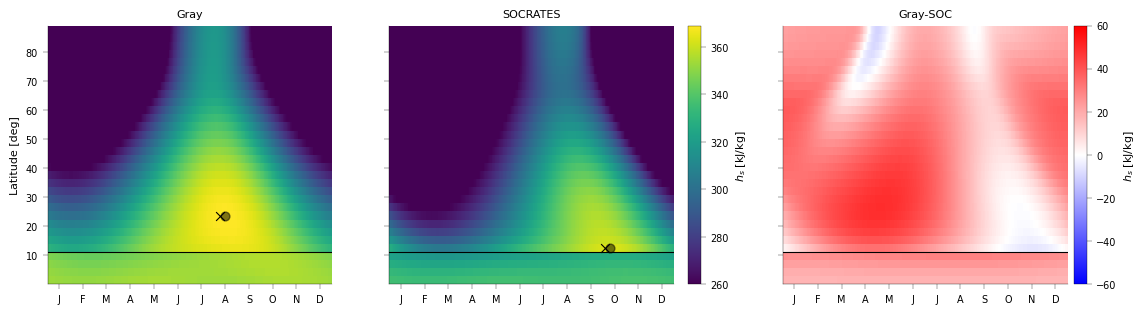

In [235]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].mse.transpose(), vmin=260, vmax=369)
    var = get_extrema_coordinates(ds[key].t_surf, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
    var = get_extrema_coordinates(ds[key].mse, 'max')
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='o', s=40, alpha=0.5)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$h_s$ [kJ/kg]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].mse.transpose(), vmin=-60, vmax=60, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$h_s$ [kJ/kg]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Relative Humidity
Relative humidity seems to be generally larger in summer for the gray case at midlatitudes and further north. It is pretty similar over ocean and in subtropics around time of hottest day.

I think on average, the relative humidity is larger for SOCRATES (especially over ocean) is because it is colder and thus less rain as shown below. Note that the winter high latitude relative humidity does not really mean anything because the temperatures are so small, there is essentially no moisture in the atmosphere.

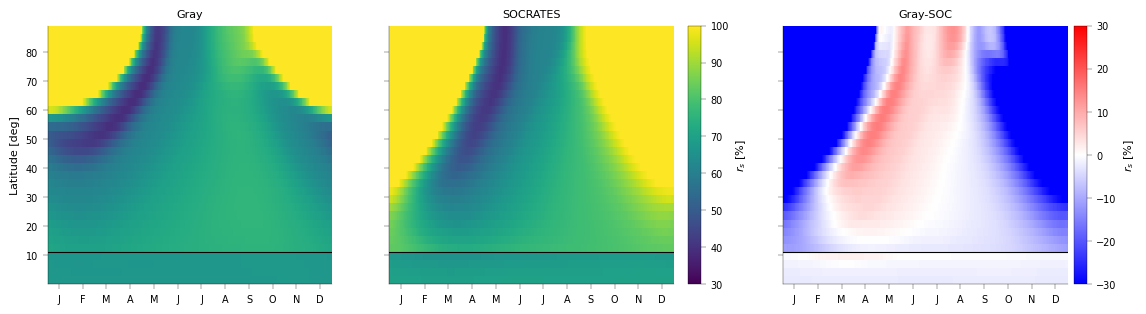

In [236]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].rh.transpose()*100, vmin=30, vmax=100)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].rh.transpose()*100, vmin=-30, vmax=30, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

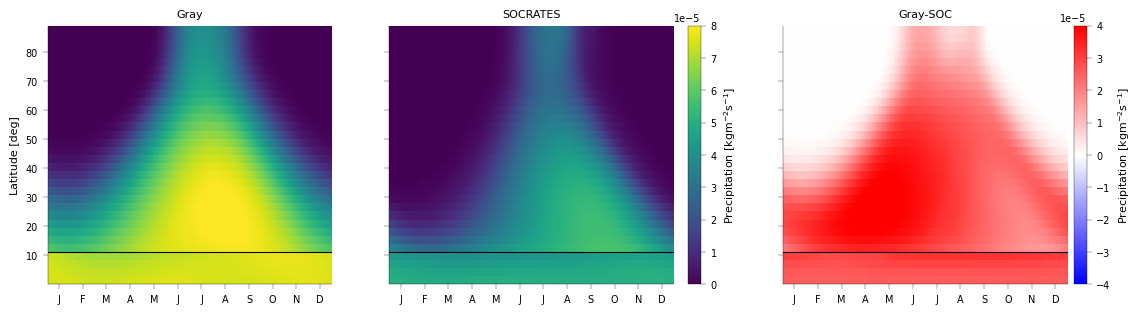

In [237]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].precipitation.transpose(), vmin=0, vmax=8e-5)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].precipitation.transpose(), cmap='bwr', vmin=-4e-5, vmax=4e-5)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

## Surface Energy Budget Parameters
Now we look at some other variables that go into the surface energy budget.
### Disequilibrium temperature,
This surface-air temperature difference, $T_{diseqb} = T_s - T_a$, is pretty similar for the two except it delayed more for SOCRATES. Again, this must be due to water vapour feedback. This is emphasized by the different hysteresis shape for a given latitude.

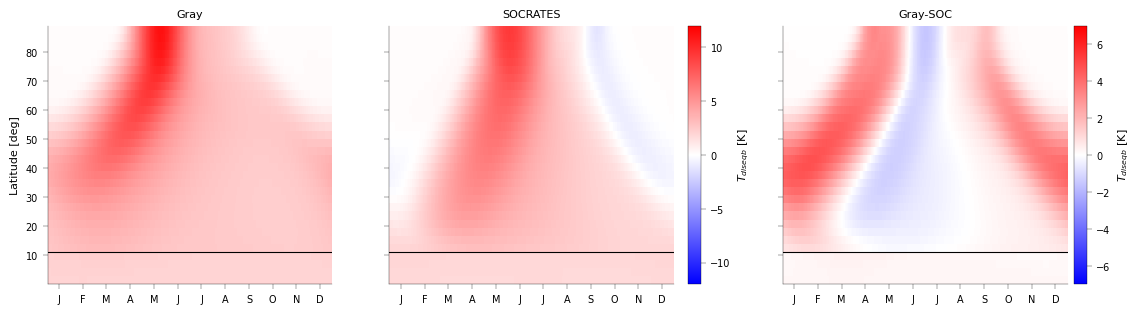

In [238]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb.transpose(), vmin=-12, vmax=12, cmap='bwr')
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].temp_diseqb.transpose(), cmap='bwr', vmin=-7, vmax=7)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

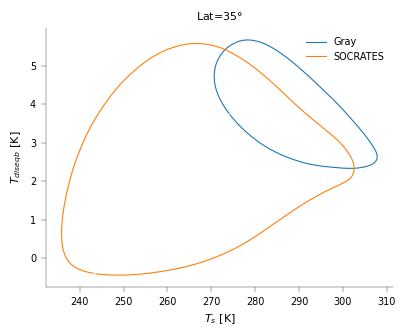

In [239]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
lat_plot_ind = 12
for key in ['gray', 'soc']:
    ax.plot(ds[key].t_surf.isel(lat=lat_plot_ind), ds[key].temp_diseqb.isel(lat=lat_plot_ind), label=exp_label[key], color=color_exp[key])
ax.set_xlabel('$T_s$ [K]')
ax.set_ylabel('$T_{diseqb}$ [K]')
ax.legend()
ax.set_title(f'Lat={ds["gray"].lat[lat_plot_ind].values:.0f}$\degree$')
plt.show()

### Optical Depth
The optical depth for the gray gas case is imposed in the simulation, and is constant in time.

For SOCRATES, there is no optical depth as a full radiative transfer is performed. However, if we assume little ozone effect, it is entirely determined by water vapour. Hence we can estimate it from the water column depth, $W = \int_0^{p_s} q/g dp$: $\tau = \kappa W$ where $\kappa$ is a mass absorption coefficient, which we estimate as 0.05 here. This then clearly is peaked in the hottest days, as shown below.

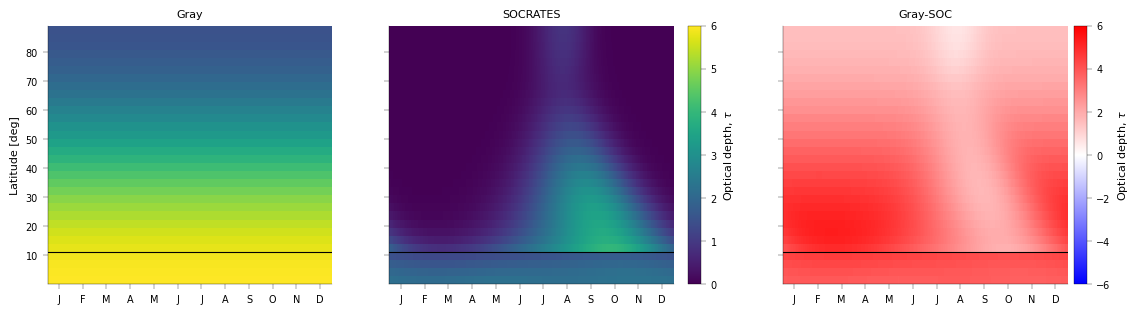

In [377]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, (ds[key].ps*0+opd_lw_gray(ds[key].lat)).transpose() if key=='gray'
    else ds[key].opd_water.transpose(), vmin=0, vmax=6)
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, opd_lw_gray(ds[key].lat) - ds['soc'].opd_water.transpose(), cmap='bwr', vmin=-6, vmax=6)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Radiative Disequilibrium Temperature
The downward longwave radiation reaching the surface is given by $LW^{\downarrow} = \sigma T_r^4 (1-e^{-\tau})$. From this and the above equation for optical depth, we can then compute $T_r$. Below, we show the difference, $T_{diseqb,r}=T_a - T_r$, between the near-surface air and radiative temperature.

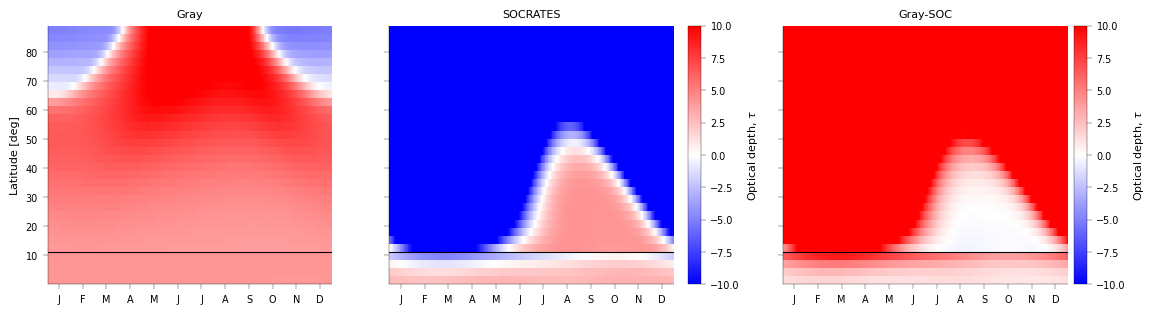

In [390]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['gray', 'soc']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb_rad_gray.transpose() if key=='gray'
    else ds[key].temp_diseqb_rad_water.transpose(), vmin=-10, vmax=10, cmap='bwr')
fig.colorbar(im, ax=ax[:2].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, (ds['gray'].temp_diseqb_rad_gray - ds['soc'].temp_diseqb_rad_water).transpose(),
                      cmap='bwr', vmin=-10, vmax=10)
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Optical depth, $\\tau$')
for i, key in enumerate(ds):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

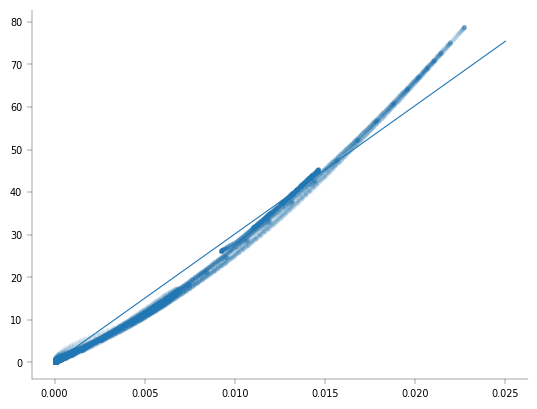

In [299]:
plt.scatter(ds['soc'].sphum.isel(pfull=0), ds['soc'].water_depth, alpha=0.05)
var = np.linalg.lstsq(ds['soc'].sphum.isel(pfull=0).values.flatten()[:, np.newaxis], ds['soc'].water_depth.values.flatten(), rcond=None)[0][0]
plt.plot(np.linspace(0, 0.025, 500), var*np.linspace(0, 0.025, 500))

## Surface Fluxes and estimates
Here we show the surface fluxes associated with the surface energy budget, as well as approximate values obtained using constant variables except for surface temperature. I.e. the variation due to just surface energy fluxes.


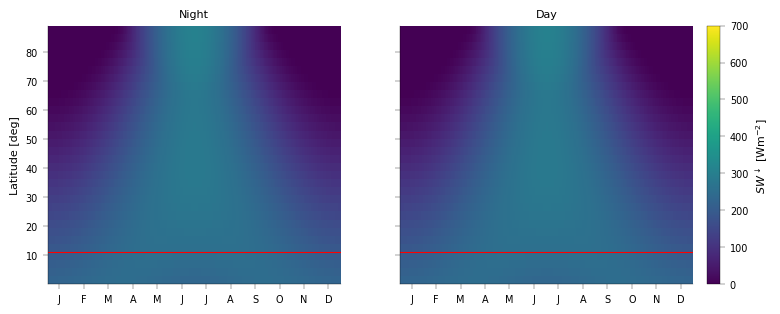

In [57]:
show_overview_figs = True
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].swdn_sfc.transpose(), vmin=0, vmax=700)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$SW^{\\downarrow}$ [Wm$^{-2}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

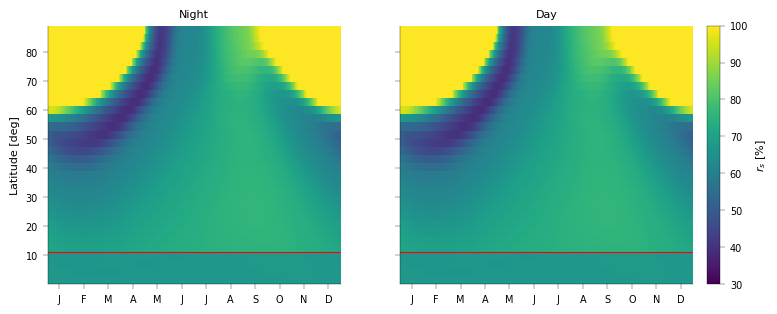

In [58]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].rh.transpose()*100, vmin=30, vmax=100)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$r_s$ [%]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

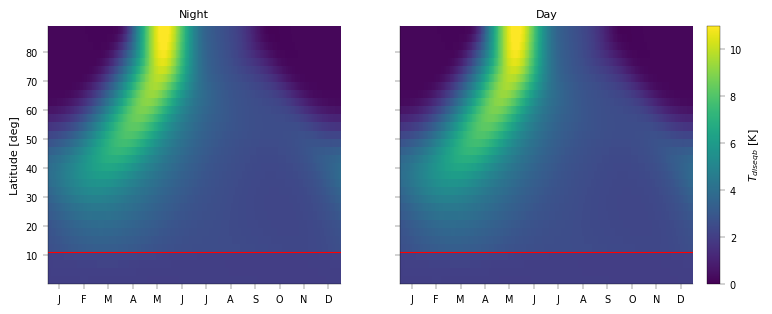

In [59]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].temp_diseqb.transpose(), vmin=0, vmax=11)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

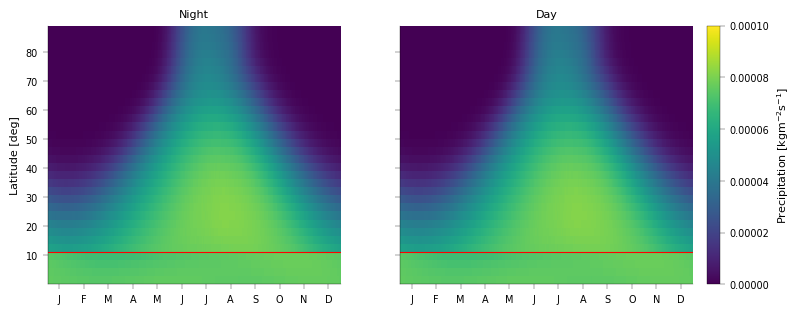

In [60]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].precipitation.transpose(), vmin=0, vmax=10e-5)
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

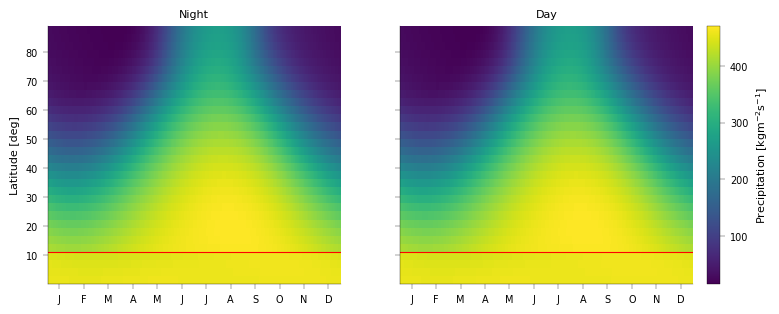

In [61]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i, key in enumerate(['night', 'day']):
    im = ax[i].pcolormesh(ds[key].dayofyear, ds[key].lat, ds[key].lwdn_sfc.transpose())
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

### Diurnal Cycle
Below, I plot the diurnal cycle of temperature at various levels; followed by the latent and sensible heat plots.

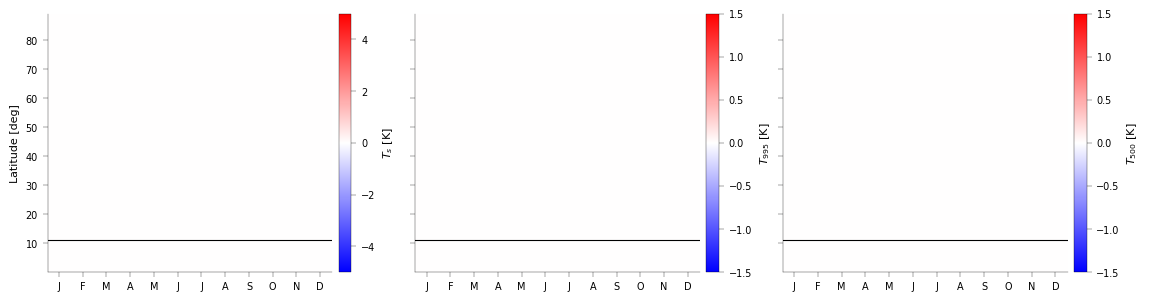

In [62]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
im = ax[0].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].t_surf.transpose(), cmap='bwr', vmin=-5, vmax=5)
plt.colorbar(im, ax=ax[0], fraction=0.05, pad=0.02, label='$T_s$ [K]')
im = ax[1].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].temp[:, ind_surf].transpose(), cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(im, ax=ax[1], fraction=0.05, pad=0.02, label=f'$T_{"{"+str(int(round(p_surface/100, 0)))+"}"}$ [K]')
im = ax[2].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds['diff'].temp[:, ind_ft].transpose(), cmap='bwr', vmin=-1.5, vmax=1.5)
plt.colorbar(im, ax=ax[2], fraction=0.05, pad=0.02, label=f'$T_{"{"+str(pressure_ft)+"}"}$ [K]')
for i in range(3):
    ax[i].axhline(lat_land_min, color='k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

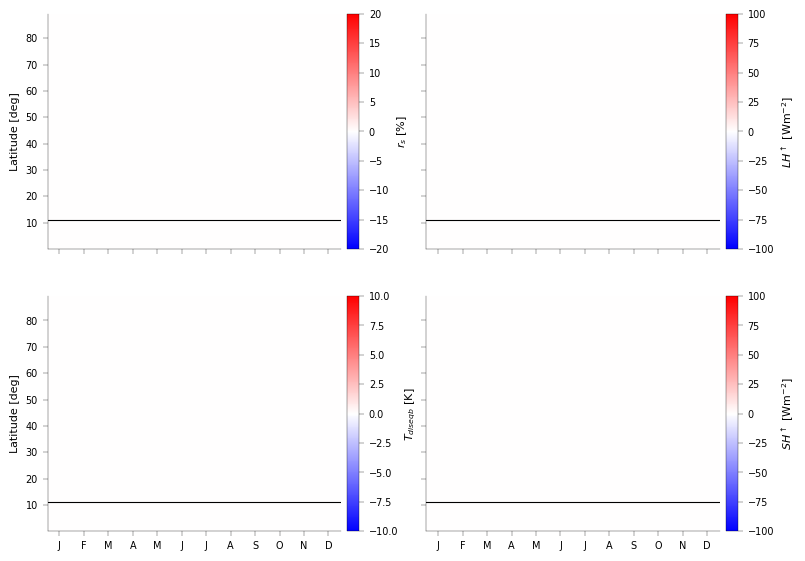

In [63]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
im = ax[0, 0].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].rh.transpose()*100, cmap='bwr', vmin=-20, vmax=20)
plt.colorbar(im, ax=ax[0, 0], fraction=0.05, pad=0.02, label='$r_s$ [%]')
im = ax[0, 1].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].flux_lhe.transpose(), cmap='bwr', vmin=-100, vmax=100)
plt.colorbar(im, ax=ax[0, 1], fraction=0.05, pad=0.02, label='$LH^{\\uparrow}$ [Wm$^{-2}$]')
im = ax[1, 0].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].temp_diseqb.transpose(), cmap='bwr', vmin=-10, vmax=10)
plt.colorbar(im, ax=ax[1, 0], fraction=0.05, pad=0.02, label='$T_{diseqb}$ [K]')
im = ax[1, 1].pcolormesh(ds['day'].dayofyear, ds['day'].lat,
                      ds['diff'].flux_t.transpose(), cmap='bwr', vmin=-100, vmax=100)
plt.colorbar(im, ax=ax[1, 1], fraction=0.05, pad=0.02, label='$SH^{\\uparrow}$ [Wm$^{-2}$]')
for ax_use in ax.flatten():
    ax_use.axhline(lat_land_min, color='k')
ax[0,0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
if show_overview_figs:
    plt.show()
else:
    plt.close()

In [64]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Hottest Day of the Year
Below, we plot the location of the hottest day of the year with white markers. It is clear, that it is the same regardless of the time of they that you want to compute it (although hottest morning day is actually in the ocean).

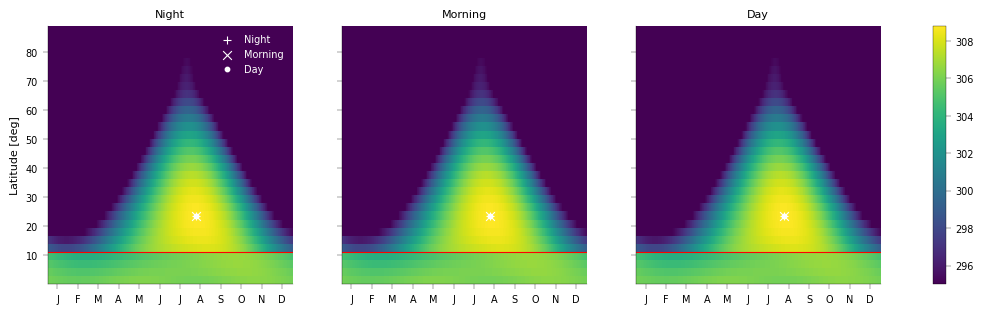

In [65]:
coords_max_temp = {key: get_extrema_coordinates(ds[key].t_surf.where(ds[key].lat>lat_land_min, drop=True)) for key in ds}
marker_use = {'night': '+', 'morning':'x', 'day': '.'}
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*3)
for i, key in enumerate(['night', 'morning', 'day']):
    im=ax[i].pcolormesh(ds['day'].dayofyear, ds['day'].lat, ds[key].t_surf.transpose(), vmin=295, vmax=ds['day'].t_surf.max())
    for key2 in ['night', 'morning', 'day']:
        ax[i].scatter(coords_max_temp[key2]['dayofyear'], coords_max_temp[key2]['lat'], color='w', marker=marker_use[key2], s=40, label=key2.capitalize())
    ax[i].set_title(key.capitalize())
    ax[i].axhline(lat_land_min, color='r')
plt.colorbar(im, ax=ax.ravel())
ax[0].legend(labelcolor='w')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Net input radiation
We were wondering if the hottest day is simply the day which has the most net radiation into the surface. Clearly, this is not the case as shown below, whereby the day with max day-time temperature tendency at the location of the hottest day is in March.

This is not really surprising, as from above the morning of the hottest day is also the hottest morning; so it does not need the largest tendency as well. I.e. if all days had the same morning temperature, then the day with most net radiation into surface would be the hottest day.

Also, the hotter the day, the larger the upward longwave and latent heat fluxes, so it is not surprising that the hot day has fairly average to low temperature tendency.

So something varying on the time scale of days is setting the underlying seasonal daily average temperature cycle; and the diurnal cycle acts on top of this.

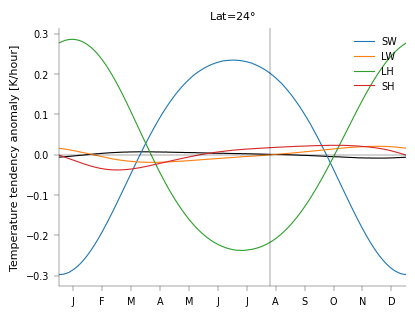

In [66]:
def get_anom(ds, dim='dayofyear'):
    return ds - ds.mean(dim=dim)

n_seconds_hour = 60**2
ds_use = ds['day'].sel(lat=coords_max_temp['day']['lat'])

fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
ax.plot(ds_use.dayofyear, get_anom(ds_use.flux_sfc_dn_net)/ds_use.heat_capacity*n_seconds_hour, color='k')
ax.plot(ds_use.dayofyear, get_anom(ds_use.swdn_sfc)/ds_use.heat_capacity*n_seconds_hour, label='SW')
ax.plot(ds_use.dayofyear, get_anom(ds_use.lwdn_sfc-ds_use.lwup_sfc)/ds_use.heat_capacity*n_seconds_hour, label='LW')
ax.plot(ds_use.dayofyear, -get_anom(ds_use.flux_lhe)/ds_use.heat_capacity*n_seconds_hour, label='LH')
ax.plot(ds_use.dayofyear, -get_anom(ds_use.flux_t)/ds_use.heat_capacity*n_seconds_hour, label='SH')
ax.axvline(coords_max_temp['day']['dayofyear'], color='k', lw=ax_linewidth)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend()
ax.set_xticks(*month_ticks)
ax.set_xlim(0, 360)
ax.set_ylabel('Temperature tendency anomaly [K/hour]')
ax.set_title('Lat={:.0f}$\degree$'.format(ds_use.lat))
plt.show()
# get_anom(ds_use.swdn_sfc).plot(label='SWDN')
# ds_use.flux_lhe.plot()
# ds_use.flux_t.plot()
# ds_use.lwdn_sfc.plot()
# ds_use.lwup_sfc.plot()

### Optical Depth Variation with latitude
Below I compare the variation with latitude of the emission factor versus the imposes surface longwave optical depth. The emission factor is smaller because the radiative emission temperature is lower than that of the near-surface.

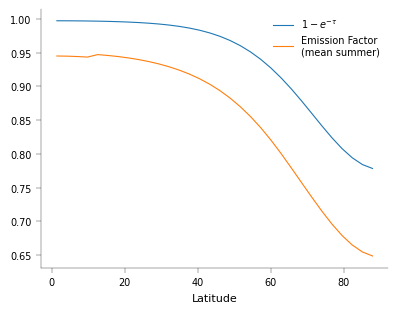

In [89]:
time_summer = slice(150, 230)
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
ax.plot(ds['day'].lat, 1 - np.exp(-opd_lw_gray(ds['day'].lat)), label='$1-e^{-\\tau}$')
ax.plot(ds['day'].lat, ds['day']['emission_factor'].sel(dayofyear=time_summer).mean(dim='dayofyear'), label='Emission Factor\n(mean summer)')
ax.legend()
ax.set_xlabel('Latitude')
plt.show()

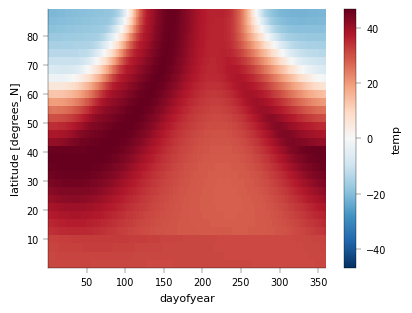

In [91]:
# Plot lapse rate to show unphysical at poles
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col'])
(ds['day']['temp'].isel(pfull=0) - ds['day']['temp'].isel(pfull=1)).transpose().plot(ax=ax)
plt.show()

In [111]:
def get_land_median_var(ds, var):
    return float(ds[var].sel(lat=slice(lat_land_min, np.inf)).median())
const_params = {var: get_land_median_var(ds['day'], var) for var in ['ps', 'drag_q', 'rh', 'temp_diseqb', 'temp_diseqb_rad']}
const_params['w_atm'] = w_atm_const
const_params

{'ps': 100000.0,
 'drag_q': 0.0011636314447969198,
 'rh': 0.7144337296485901,
 'temp_diseqb': 2.774156093597412,
 'temp_diseqb_rad': 5.678076086304388,
 'w_atm': 5}

In [116]:
def get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

def get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf*sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf*(1-sigma**(-kappa)) +temp_diseqb*sigma**(-kappa))

def get_lwdn_surf(temp_surf, temp_diseqb, temp_diseqb_rad, opd):
    emission_factor = 1 - np.exp(-opd)
    temp_rad = temp_surf - temp_diseqb - temp_diseqb_rad
    return Stefan_Boltzmann * temp_rad**4 * emission_factor

def get_temp_tendency(temp_surf, swdn_sfc, opd, temp_diseqb=const_params['temp_diseqb'], temp_diseqb_rad=const_params['temp_diseqb_rad'],
                      rh=const_params['rh'], p_surf=const_params['ps'], wind_speed=const_params['w_atm'],
                      drag_coef=const_params['drag_q'], sigma=sigma_near_surf, mixed_layer_depth=mixed_layer_depth['land']):
    heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
    lwup_sfc = Stefan_Boltzmann * temp_surf**4
    lwdn_sfc = get_lwdn_surf(temp_surf, temp_diseqb, temp_diseqb_rad, opd)
    lhup = get_latent_heat(temp_surf, temp_diseqb, rh, p_surf, wind_speed, drag_coef, sigma, virtual=False)
    shup = get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_coef, sigma, virtual=False)
    return (swdn_sfc + lwdn_sfc - lwup_sfc - lhup - shup)/heat_capacity


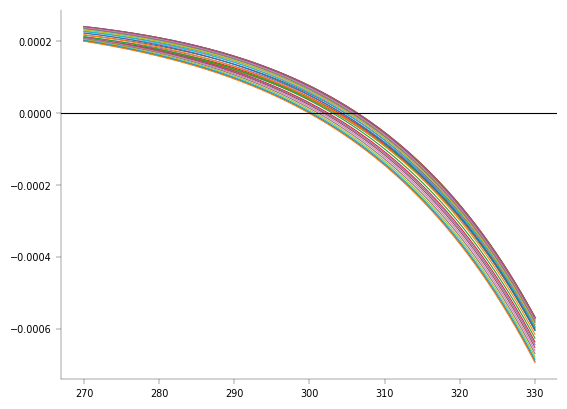

In [151]:
temp_tendency_t_surf_vals = np.linspace(270, 330, 800)
temp_surf_eqb = np.zeros(ds['day'].lat.size)
for i in range(0, ds['day'].lat.size):
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['day']['swdn_sfc'].isel(lat=i).max()),
                            float(opd_lw_gray(ds['day'].lat.isel(lat=i))))
    temp_surf_eqb[i] = temp_tendency_t_surf_vals[np.argmin(np.abs(var))]
    plt.plot(temp_tendency_t_surf_vals, var)
# lat_use = 90
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
# lat_use = 0
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
# lat_use = 60
# a = get_temp_tendency(np.linspace(270, 330, 50), float(ds['day']['swdn_sfc'].sel(lat=lat_use, method='nearest').max()),
#                       float(opd_lw_gray(ds['day'].lat.sel(lat=lat_use, method='nearest'))))
# plt.plot(np.linspace(270, 330, 50), a)
plt.axhline(0, color='k')

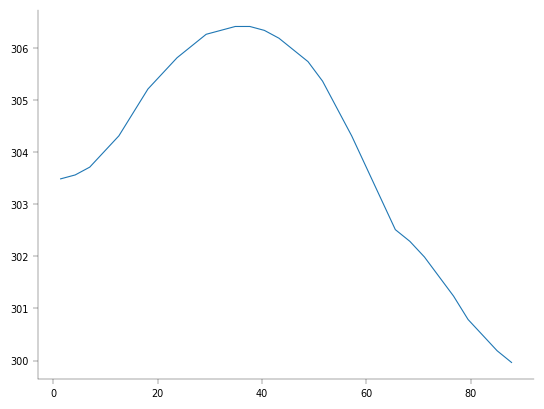

In [152]:
plt.plot(ds['day'].lat, temp_surf_eqb)

In [154]:
a = xr.load_dataset('/Users/joshduffield/Documents/StAndrews/Isca/jobs/benchmarking/experiments/socrates/ozone_1990.nc', decode_times=False)

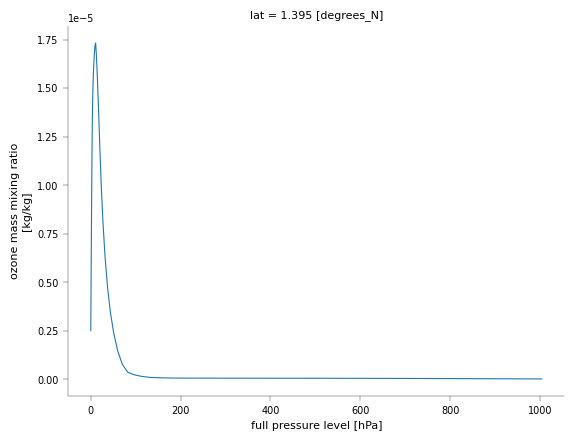

In [172]:
a.isel(time=5, lon=0, drop=True).ozone_1990.sel(lat=0, method='nearest').plot()

In [183]:
ds_use = isca_tools.load_dataset(exp_dir + exp_name[0], decode_times=True)